In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.fftpack as fft
from astropy.io import fits
from scipy import optimize
from poppy import zernike
import os
import pytz

/Users/MelisaT/anaconda/lib/python3.6/site-packages/pysynphot/locations.py:46: UserWarning: PYSYN_CDBS is undefined; functionality will be SEVERELY crippled.
  warnings.warn("PYSYN_CDBS is undefined; functionality will be SEVERELY "
/Users/MelisaT/anaconda/lib/python3.6/site-packages/pysynphot/locations.py:329: UserWarning: Extinction files not found in extinction
  warnings.warn('Extinction files not found in %s' % (extdir, ))


In [52]:
from matplotlib import rc
rc('axes', linewidth=1)

parameters

In [2]:
outD = 7.77010            # primary diameter (m)
inD = 1.024               # inner M2 diameter (m)
n = 48                    # number sample points across the screen (Not the number of subapertures)
nacross = 43              # number of subapertures across the aperture
pscale = outD/(nacross)   # pixel size (m) of samples in pupil plane

aperture

In [3]:
#  Aperture containing zeros
x = np.linspace(-(n)/2,(n)/2,n)*pscale 
y = np.linspace(-(n)/2,(n)/2,n)*pscale
mg = np.meshgrid(x,y)
ar = np.sqrt(np.sum((m**2 for m in mg)))
ap_outer = (ar <= outD/2)
ap_inner = (ar <= inD/2)   
ap = (ap_outer ^ ap_inner).astype(int)

#  Aperture containing nans
ap_nan = np.copy(ap.astype(np.float))  
ap_nan[np.where(ap==0)] = np.nan

frequency grid

In [4]:
kx = fft.fftshift(fft.fftfreq(n,pscale))
ky = fft.fftshift(fft.fftfreq(n,pscale))
mg = np.meshgrid(kx,ky)
kr = np.sqrt(np.sum((m**2 for m in mg))) 

import file

In [168]:
#filename = "/Users/melisatallis/Documents/Research/GPIDomeSeeing/data/aotelem/aored_When_2016.2.27_0.40.14_poldm_phase.fits"
#filename = "/Users/melisatallis/Documents/Research/GPIDomeSeeing/data/aotelem/aored_When_2016.2.29_22.29.18_poldm_phase.fits"
filename = "/Users/MelisaT/Documents/Research/GPIDomeSeeing/data/Reduced/20160227/aored_When_2016.2.27_4.3.55_poldm_phase.fits"


hdulist = fits.open(filename,memmap=True)
phase = hdulist[0].data.astype('float')

# Get the phase dimensions
timesteps, phx, phy = phase.shape 

plotting functions

In [6]:
def radialProfile(image, center=None):
    """
    Calculate the avearge radial profile.

    image - The 2D image
    center - The [x,y] pixel coordinates used as the center. The default is 
             None, which then uses the center of the image (including 
             fracitonal pixels).
    
    """
    ## Calculate the indices from the image
    y,x = np.indices((image.shape)) # first determine radii of all pixels
    
    if not center:
        center = np.array([(x.max()-x.min())/2.0, (y.max()-y.min())/2.0])
     
    r = np.hypot(x - center[0], y - center[1]).astype(np.int) 
    
    n = np.bincount(r.ravel())
    sy = np.bincount(r.ravel(), image.ravel())
    mean = sy/n
    
    return mean

def implot(image, display=True, **kwargs):
    """Plot an image with colorbar.
    
    image - The 2d image
    kwargs - settings for curstomizing plot"""

    ## Create matplotlib figure 
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    cax = ax.imshow(image, cmap = plt.cm.Greys, origin='lower', interpolation='none')
    cbar = fig.colorbar(cax, orientation='vertical')

    ## Modify plot based on keyword arguments
    if 'title' in kwargs: ax.set_title(kwargs['title'], fontsize=24)
    if 'xlabel' in kwargs: ax.set_xlabel(kwargs['xlabel'], fontsize=16)
    if 'ylabel' in kwargs: ax.set_ylabel(kwargs['ylabel'], fontsize=16)
    if 'cbar_label' in kwargs: cbar.set_label(kwargs['cbar_label'], 
                                              fontsize=18)
    if 'save_image' in kwargs: plt.savefig(kwargs['save_image'])

    if display: plt.show()

simulating kolmogorowv phase

In [83]:
k = np.sqrt(kr)
k[k==0] = 1
Phi = k**(-11./3.)


f = (np.random.randn(48,48)+1j*np.random.randn(48,48))*np.sqrt(Phi)
f = np.fft.ifftshift(f)
f = np.fft.ifft2(f)
sim_phase = np.real(f)*25

In [8]:
sim_phase.shape

(48, 48)

plotting simulation

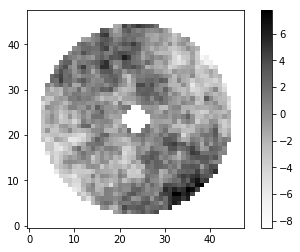

In [11]:
implot((phase[0]-sim_phase)*ap_nan)

In [28]:
phFT[0,0]

array([  3.09069969e-03+0.j        ,  -8.89044580e-04+0.00272496j,
         3.86027940e-03-0.00195542j,   3.37871167e-05+0.00012109j,
        -5.55313791e-03+0.00135359j,   5.24213903e-04-0.00216512j,
        -1.47921992e-03+0.00094521j,   1.48735984e-03+0.00255467j,
        -5.02297164e-03-0.00140716j,   4.25682437e-04-0.00284106j,
         3.94599033e-03+0.0027075j ,   2.59518408e-03+0.0035259j ,
         4.20547388e-03-0.00401024j,   3.53513932e-03-0.00272105j,
        -6.93905023e-03+0.00412135j,  -3.92095916e-03-0.00467384j,
        -2.56384250e-03+0.00359175j,   1.12720065e-03-0.00113581j,
         3.63330430e-03-0.00074704j,  -2.97347137e-03+0.00303885j,
         3.02453963e-03-0.00332024j,  -3.07377112e-03-0.00368982j,
         4.55123597e-03+0.00909802j,  -3.00806175e-03+0.00010799j,
         1.85757897e-03+0.j        ,  -3.00806175e-03-0.00010799j,
         4.55123597e-03-0.00909802j,  -3.07377112e-03+0.00368982j,
         3.02453963e-03+0.00332024j,  -2.97347137e-03-0.003038

In [203]:
avg_phase = np.nanmean(sim_phase*ap_nan)  # used to find average zernikes 
    
# remove zernikes form cube
z_basis = zernike.zernike_basis_faster(nterms= 3, npix = 48)
z_coeff = zernike.opd_expand_nonorthonormal(sim_phase, aperture=ap, nterms=3)
thin_lens = np.sum(z_coeff[:,None,None]*z_basis[:,:,:],axis=0)

c_phase = (sim_phase-thin_lens)*ap_nan
c_phase[np.isnan(c_phase)]=0.
print('Done removing zernikes')
    
# computer fourier transform of cube
phFT = fft.fftshift(fft.fft2(c_phase))/ap.sum()
print('Done with FT')
        
# compute 2d psd cube
psd2D = np.zeros((phx, phy),dtype=float)
for k in np.arange(phx):
    for l in np.arange(phy):
        psd2D[k,l] = np.abs(phFT[k,l])**2
print('Done with PSD')    
    
# compute radial average of 2d psd cube and frequency
psd1D =  radialProfile(psd2D)
freq = radialProfile(kr)

Done removing zernikes
Done with FT
Done with PSD


In [192]:
avg_phase = np.nanmean(sim_phase*ap_nan)  # used to find average zernikes 
    
# remove zernikes form cube
z_basis = zernike.zernike_basis_faster(nterms= 3, npix = 48)
z_coeff = zernike.opd_expand_nonorthonormal(sim_phase, aperture=ap, nterms=3)
thin_lens = np.sum(z_coeff[:,None,None]*z_basis[:,:,:],axis=0)

s_phase = (sim_phase)*ap_nan
s_phase[np.isnan(s_phase)]=0.
print('Done removing zernikes')
    
# computer fourier transform of cube
phFT = fft.fftshift(fft.fft2(s_phase))/ap.sum()
print('Done with FT')
        
# compute 2d psd cube
psd2D = np.zeros((phx, phy),dtype=float)
for k in np.arange(phx):
    for l in np.arange(phy):
        psd2D[k,l] = np.abs(phFT[k,l])**2
print('Done with PSD')    
    
# compute radial average of 2d psd cube and frequency
s_psd1D =  radialProfile(psd2D)


Done removing zernikes
Done with FT
Done with PSD


In [118]:
psd1D

array([  5.12798790e-04,   1.46885722e-03,   2.05292172e-03,
         9.47108869e-04,   5.65995012e-04,   4.29080444e-04,
         3.91033378e-04,   3.54315576e-04,   1.90547798e-04,
         1.61205952e-04,   1.94774401e-04,   1.85644511e-04,
         1.24462162e-04,   9.83438007e-05,   7.87891462e-05,
         5.65512333e-05,   5.23347459e-05,   4.95541517e-05,
         5.56758348e-05,   5.47621044e-05,   4.65111061e-05,
         3.78436837e-05,   3.53214429e-05,   3.59528155e-05,
         3.27765837e-05,   3.08518489e-05,   2.39196573e-05,
         2.00715730e-05,   2.43550160e-05,   1.72516322e-05,
         1.87987809e-05,   1.93380997e-05,   3.59992858e-05,
         1.36437796e-05])

In [193]:
dif = s_psd1D - psd1D

processing real images

In [129]:
np.nanmean(avg_phase)

0.06602759452974015

# Main 

In [177]:
avg_phase = np.nanmean(phase*ap_nan,axis=0)  # used to find average zernikes 
    
# remove zernikes form cube
z_basis = zernike.zernike_basis_faster(nterms= 6, npix = 48)
z_coeff = zernike.opd_expand_nonorthonormal(avg_phase, aperture=ap, nterms=6)
thin_lens = np.sum(z_coeff[:,None,None]*z_basis[:,:,:],axis=0)

c_phase = (phase - thin_lens[None,:,:])*ap_nan
c_phase[np.isnan(c_phase)]=0.
print('Done removing zernikes')
    
# computer fourier transform of cube
phFT = np.zeros((timesteps,phx,phy), dtype=complex)
for t in np.arange(timesteps):
    phFT[t,:,:] = fft.fftshift(fft.fft2(c_phase[t,:,:]))/ap.sum()
print('Done with FT')
        
# compute 2d psd cube
psd2D = np.zeros((timesteps, phx, phy),dtype=float)
for k in np.arange(phx):
    for l in np.arange(phy):
        psd2D[:,k,l] = np.abs(phFT[:,k,l])**2
avg_psd2D = np.mean(psd2D, axis=0)
print('Done with PSD')    
    
# compute radial average of 2d psd cube and frequency
avg_psd1D =  radialProfile(avg_psd2D)
freq = radialProfile(kr)

/Users/MelisaT/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.


Done removing zernikes
Done with FT
Done with PSD


In [148]:
avg_phase = np.nanmean(phase*ap_nan,axis=0)  # used to find average zernikes 
    
# remove zernikes form cube
z_basis = zernike.zernike_basis_faster(nterms= 6, npix = 48)
z_coeff = zernike.opd_expand_nonorthonormal(avg_phase, aperture=ap, nterms=6)
thin_lens = np.sum(z_coeff[:,None,None]*z_basis[:,:,:],axis=0)

o_phase = (phase)*ap_nan
o_phase[np.isnan(o_phase)]=0.
print('Done removing zernikes')
    
# computer fourier transform of cube
phFT = np.zeros((timesteps,phx,phy), dtype=complex)
for t in np.arange(timesteps):
    phFT[t,:,:] = fft.fftshift(fft.fft2(o_phase[t,:,:]))/ap.sum()
print('Done with FT')
        
# compute 2d psd cube
psd2D = np.zeros((timesteps, phx, phy),dtype=float)
for k in np.arange(phx):
    for l in np.arange(phy):
        psd2D[:,k,l] = np.abs(phFT[:,k,l])**2
avg_psd2D = np.mean(psd2D, axis=0)
print('Done with PSD')    
    
# compute radial average of 2d psd cube and frequency
o_avg_psd1D =  radialProfile(avg_psd2D)
freq = radialProfile(kr)

/Users/MelisaT/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.


Done removing zernikes
Done with FT
Done with PSD


In [159]:
dif = o_avg_psd1D - avg_psd1D

<IPython.core.display.Javascript object>


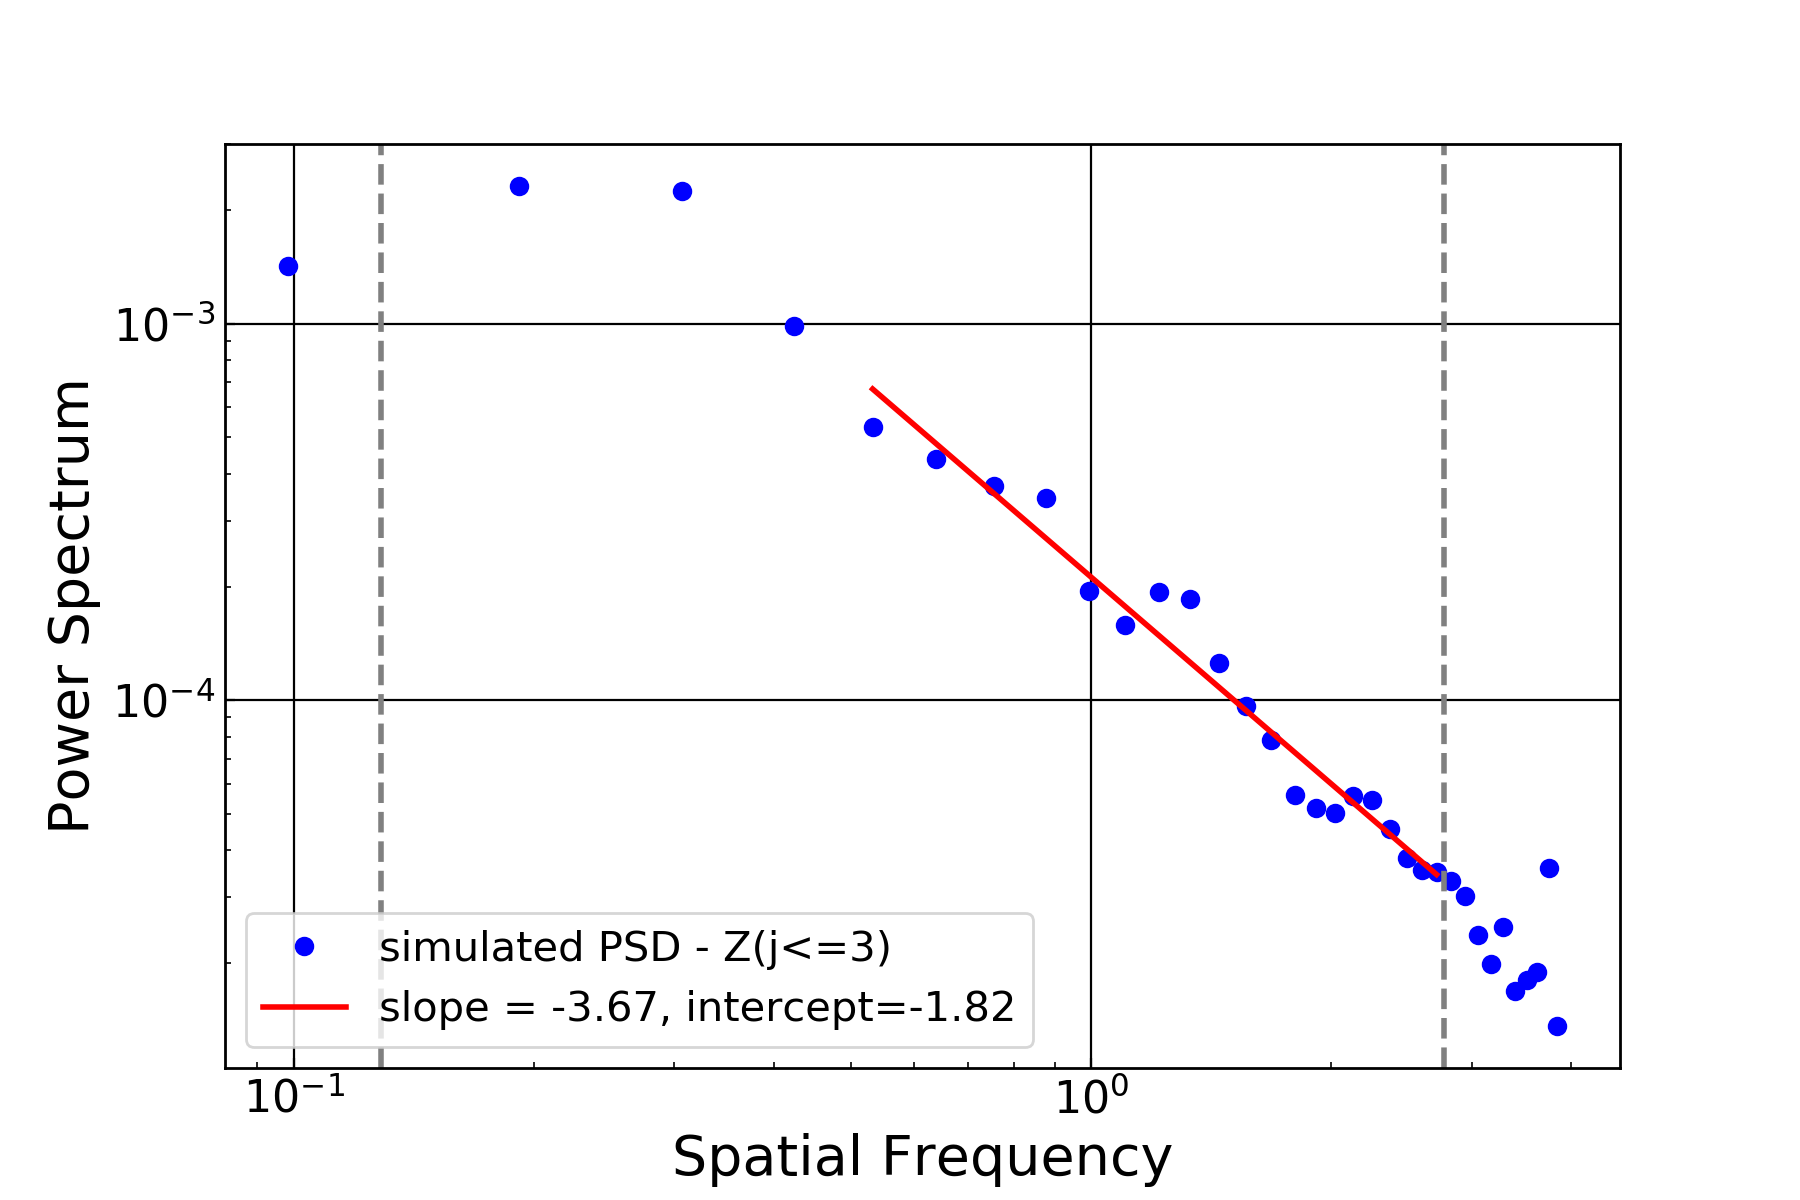

In [204]:
%matplotlib notebook

outdir = '/Users/MelisaT/Documents/Research/GPIDomeSeeing/data/sp_psd/'
#outdir = '/Users/melisatallis/Documents/Research/GPIDomeSeeing/data/aotelem/sp_psd/'
    
low_bound = 1/(nacross*pscale)
up_bound = 1/(2*pscale)

fig = plt.figure(figsize=[9,6])
ax = fig.add_subplot(111)

def func(x, a, b):
    return a+(b*x) 
    
par,pcov = optimize.curve_fit(func,np.log10(freq[(freq > 4*low_bound) & (freq < up_bound)]),
                                np.log10(psd1D[(freq > 4*low_bound) & (freq < up_bound)]), p0=(1, -3.5))
slope = par[0]
intercept = par[1]
    
img = ax.loglog((freq),(psd1D),
                'bo',(freq[(freq > 4*low_bound) & (freq < up_bound)]),
                10**(func(np.log10(freq[(freq > 4*low_bound) & (freq < up_bound)]),*par)), 'r',lw=2)

#img = ax.semilogx((freq),(dif),'b^')

ax.legend(['simulated PSD - Z(j<=3)', 'slope = {0:.2f}, intercept={1:.2f}'.format(slope, intercept)],loc=3, fontsize=15)
ax.tick_params(axis='both', which='both', labelsize=16,direction='in')
ax.grid(b=True, which='major', color='k', linestyle='-') 
ax.set_ylabel('Power Spectrum',fontsize=20)
ax.set_xlabel('Spatial Frequency',fontsize=20)

#ax.set_ylabel('PSD before - PSD after removing Zj <= 3',fontsize=15)
#ax.set_xlabel('Spatial Frequency',fontsize=15)

ax.axvline(x = low_bound,linestyle='--',color='grey',lw=2)
ax.axvline(x = up_bound,linestyle='--',color='grey',lw=2)

In [205]:
save_path = '/Users/MelisaT/Documents/Research/GPIDomeSeeing/data/sp_psd_sim_j3'
plt.savefig(save_path+'.pdf')